## TODO:

- tuning of parameters and unit of measure

BONUS:
- make a gif of the simulation
- make a slicer for the dt
- make a slicer for the particle and plot position, velocity and acceleration of that particle

CONSIDERATIONS:
- if we use an high epsilon the partices will be trapped in a local minima and they will form particluar shapes
- pay attention to the timestep: concerns energy conservation

## Dynamics

In [3]:
import sys
sys.path.append('./modules')
from tqdm import tqdm as progress

from modules import state
from modules import plot

In [2]:
CONSTANTS = {
    'DT': 0.001,
    'MAX_DISTANCE' : 6, # angstrom
    'TOTAL_PARTICLES' : 2,
    'MAX_TIME_STEPS' : 100000,
    'MASS' : 39.95,  # argon amu
    'TEMPERATURE' : 300,  # K
    'EPSILON' : 0.0105, # eV
    'SIGMA' : 3.44,  # angstrom
    'CUTOFF' : 1000  # angstrom
}


sample, energies = state.init(CONSTANTS)


for time in progress(range(CONSTANTS['MAX_TIME_STEPS'])):

    current_state  = state.get(sample, CONSTANTS)
    current_state = state.validate(current_state, CONSTANTS)
    
    state.update(sample, current_state, CONSTANTS)
    state.update_energy(sample, energies, CONSTANTS)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:21<00:00, 4643.59it/s]


## Plots

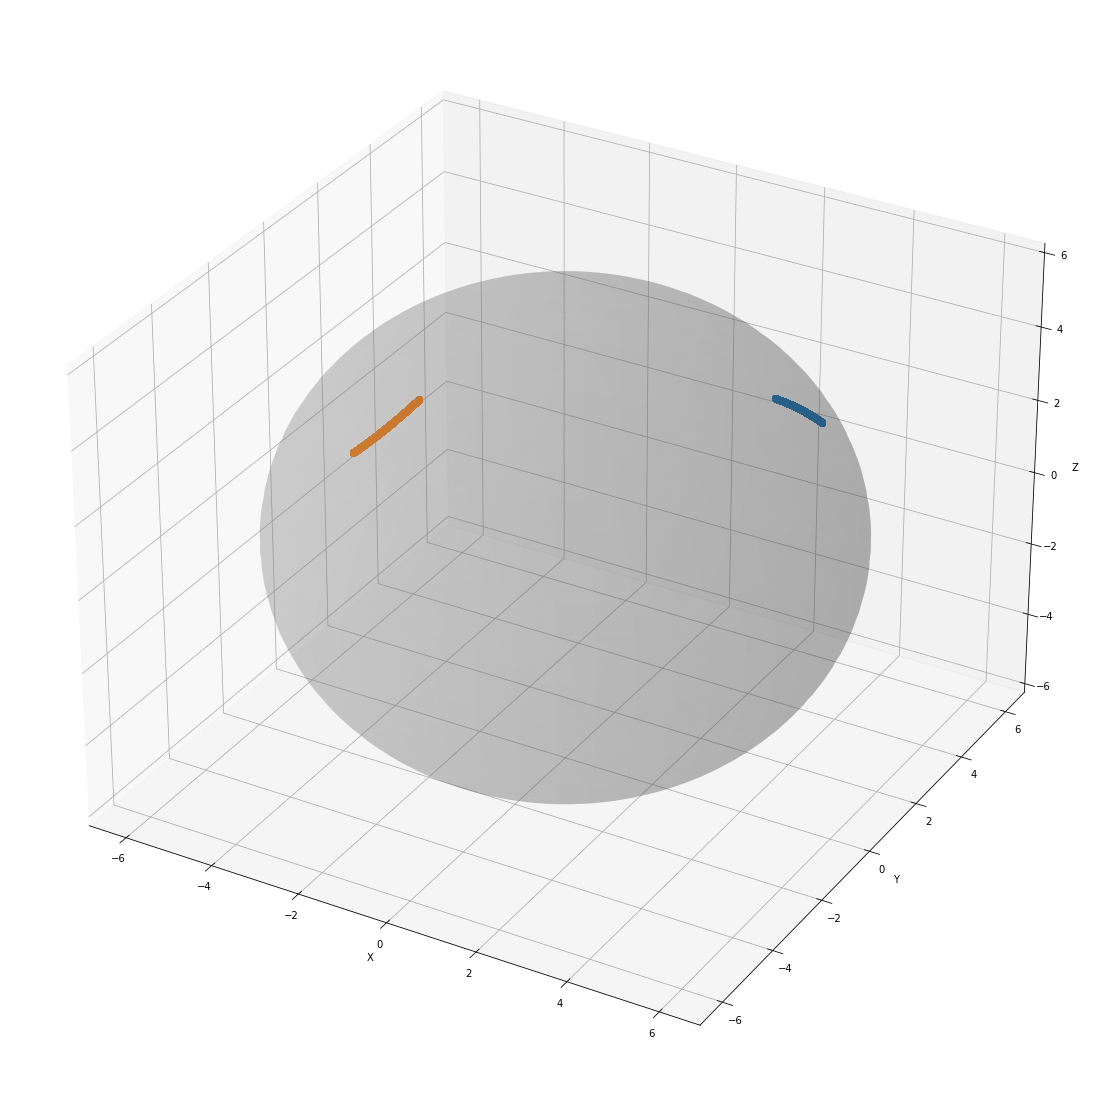

In [77]:
plot.energy(energies)
plot.particle_trajectory(sample, CONSTANTS)
plot.particle_trajectory(sample, 0)

In [12]:
def lj_potential(positions, epsilon, sigma):
    for n, position in enumerate(positions):
        positions[n] = 0.95*sigma if position < 0.95*sigma else position
    return [
        4*epsilon*((sigma/position)**12 - (sigma/position)**6)
        for position in positions
    ]

def lj_force(positions, epsilon, sigma):
    for n, position in enumerate(positions):
        positions[n] = 0.95*sigma if position < 0.95*sigma else position
    return [
        24*epsilon*((sigma**6)/(position**13))*(position**6 - 2*sigma**6)
        for position in positions
    ]

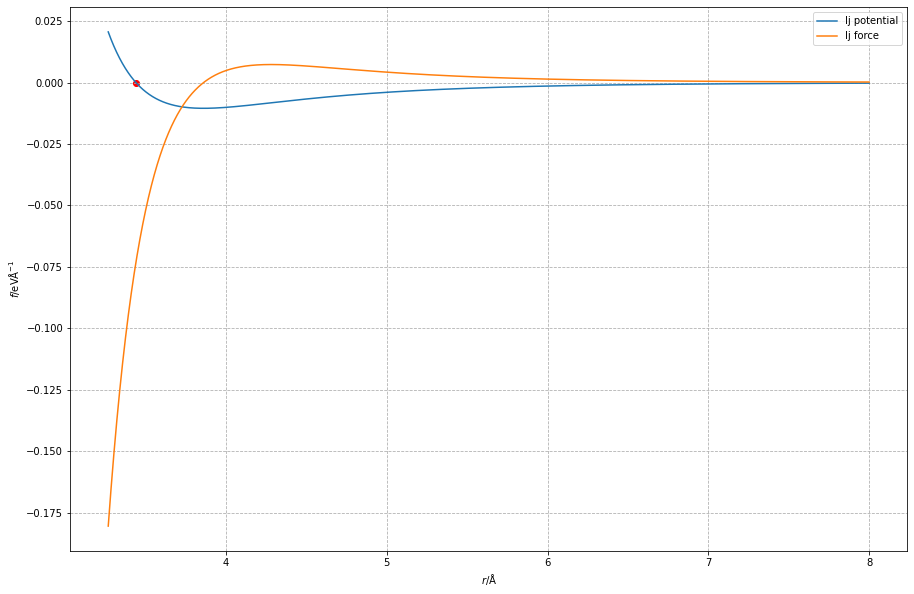

In [17]:
r = np.linspace(-3.2, 8, 10000)
plt.figure(figsize=(15,10))
plt.plot(r, lj_potential(r, EPSILON, SIGMA), label='lj potential')
plt.plot(r, lj_force(r, EPSILON, SIGMA), label='lj force')
plt.scatter(SIGMA, 0, c='r')
plt.legend()
plt.grid(linestyle='--')
plt.xlabel(r'$r$/Å')
plt.ylabel(r'$f$/eVÅ$^{-1}$')
plt.show()

## GIFs

timestep = 0
for timestep in tqdm(range(MAX_TIME_STEPS)):

    x_positions = np.array([particle['position'][timestep][0] for particle in sample.values()])
    y_positions = np.array([particle['position'][timestep][1] for particle in sample.values()])
    z_positions = np.array([particle['position'][timestep][2] for particle in sample.values()])

    fig = plt.figure(figsize=(24,7))
    fig.suptitle('Timestep: {}'.format(timestep), fontsize=25)
    
    plt.subplot(1,3,1)
    plt.scatter(x_positions, y_positions, label='xy', cmap='turbo', c=x_positions)
    plt.title('xy', fontsize=20)
    plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
    plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

    plt.subplot(1,3,2)
    plt.scatter(x_positions, z_positions, label='xz', cmap='turbo', c=x_positions)
    plt.title('xz', fontsize=20)
    plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
    plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

    plt.subplot(1,3,3)
    plt.scatter(y_positions, z_positions, label='yz', cmap='turbo', c=x_positions)
    plt.title('yz', fontsize=20)
    plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
    plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

    plt.savefig('./figures/' + str(timestep) + '.png')
    # plt.show()
    plt.close()

files = os.listdir('./figures')
with imageio.get_writer('simulation2.gif', mode='I') as writer:
    for filename in tqdm(files):
        image = imageio.imread('./figures/'+ filename)
        writer.append_data(image)

for filename in set(files):
    os.remove('./figures/'+ filename)

filenames = []
n_frames = 10
for timestep in tqdm(range(MAX_TIME_STEPS - 1)):

    x = np.array([particle['position'][timestep][0] for particle in sample.values()])
    y = np.array([particle['position'][timestep][1] for particle in sample.values()])
    z = np.array([particle['position'][timestep][2] for particle in sample.values()])
    
    x1 = np.array([particle['position'][timestep+1][0] for particle in sample.values()])
    y1 = np.array([particle['position'][timestep+1][1] for particle in sample.values()])
    z1 = np.array([particle['position'][timestep+1][2] for particle in sample.values()])

    while len(x) < len(x1):
        diff = len(x1) - len(x)
        x = x + x[:diff]
        y = y + y[:diff]
        z = z + z[:diff]
    while len(x1) < len(x):
        diff = len(x) - len(x1)
        x1 = x1 + x1[:diff]
        y1 = y1 + y1[:diff]
        z1 = z1 + z1[:diff]

    x_path = np.array(x1) - np.array(x)
    y_path = np.array(y1) - np.array(y)
    z_path = np.array(z1) - np.array(z)
    for i in np.arange(0, n_frames + 1):                

        x_temp = (x + (x_path / n_frames) * i)
        y_temp = (y + (y_path / n_frames) * i)
        z_temp = (z + (z_path / n_frames) * i)
        
        fig = plt.figure(figsize=(24,7))
        fig.suptitle('Timestep: {}'.format(timestep), fontsize=25)
        
        plt.subplot(1,3,1)
        plt.scatter(x_temp, y_temp, label='xy', cmap='turbo', c=x_temp)
        plt.title('xy', fontsize=20)
        plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
        plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

        plt.subplot(1,3,2)
        plt.scatter(x_temp, z_temp, label='xz', cmap='turbo', c=x_temp)
        plt.title('xz', fontsize=20)
        plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
        plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)

        plt.subplot(1,3,3)
        plt.scatter(y_temp, z_temp, label='yz', cmap='turbo', c=x_temp)
        plt.title('yz', fontsize=20)
        plt.xlim(-MAX_DISTANCE, MAX_DISTANCE)
        plt.ylim(-MAX_DISTANCE, MAX_DISTANCE)


        filename = f'./figures/frame_{timestep}_{i}.png'
        filenames.append(filename)
        if (i == n_frames):
            for i in range(5):
                filenames.append(filename)

        plt.savefig(filename, dpi=96)
        plt.close()



files = os.listdir('./figures')
with imageio.get_writer('simulation.gif', mode='I') as writer:
    for filename in files:
        image = imageio.imread('./figures/'+ filename)
        writer.append_data(image)

for filename in set(files):
    os.remove('./figures/'+ filename)

## Test

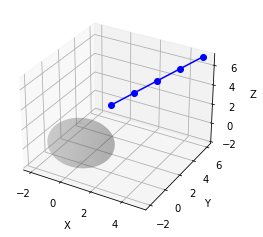

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy

def plot_particle_trajectory(x, y, z, radius):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Disegna la traiettoria della particella
    ax.plot(x, y, z, '-o', color='b')

    # Disegna la sfera di raggio r centrata nell'origine
    u = numpy.linspace(0, 2 * numpy.pi, 100)
    v = numpy.linspace(0, numpy.pi, 100)
    x_sphere = radius * numpy.outer(numpy.cos(u), numpy.sin(v))
    y_sphere = radius * numpy.outer(numpy.sin(u), numpy.sin(v))
    z_sphere = radius * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='gray', alpha=0.2)

    # Configurazione degli assi
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Mostra il grafico
    plt.show()

# Esempio di input
x = [1, 2, 3, 4, 5]
y = [2, 3, 4, 5, 6]
z = [3, 4, 5, 6, 7]
radius = 2

# Chiamata alla funzione per generare il grafico
plot_particle_trajectory(x, y, z, radius)


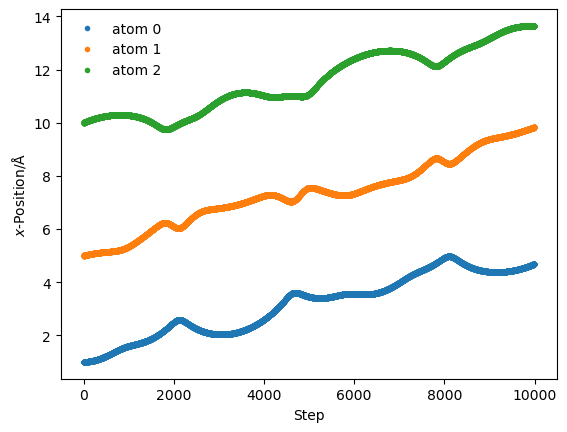

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann
mass_of_argon = 39.948 # amu

def lj_force(r, epsilon, sigma):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    r: float
        Distance between two particles (Å)
    epsilon: float 
        Potential energy at the equilibrium bond 
        length (eV)
    sigma: float 
        Distance at which the potential energy is 
        zero (Å)
    
    Returns
    -------
    float
        Force of the van der Waals interaction (eV/Å)
    """
    return 48 * epsilon * np.power(
        sigma, 12) / np.power(
        r, 13) - 24 * epsilon * np.power(
        sigma, 6) / np.power(r, 7)

def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series of 
    particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at 
        initialisation (K)
    number_of_particles: int
        Number of particles in the system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of 
        particles (eVs/Åamu)
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt(Boltzmann * T / (
        mass_of_argon * 1.602e-19))

def get_accelerations(positions):
    """
    Calculate the acceleration on each particle
    as a  result of each other particle. 
    N.B. We use the Python convention of 
    numbering from 0.
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, 
        for all of the particles
        
    Returns
    -------
    ndarray of floats
        The acceleration on each
        particle (eV/Åamu)
    """
    accel_x = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size - 1):
        for j in range(i + 1, positions.size):
            r_x = positions[j] - positions[i]
            rmag = np.sqrt(r_x * r_x)
            force_scalar = lj_force(rmag, 0.0103, 3.4)
            force_x = force_scalar * r_x / rmag
            accel_x[i, j] = force_x / mass_of_argon
            accel_x[j, i] = - force_x / mass_of_argon
    return np.sum(accel_x, axis=0)

def update_pos(x, v, a, dt):
    """
    Update the particle positions.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a 
        single dimension
    v: ndarray of floats
        The velocities of the particles in a 
        single dimension
    a: ndarray of floats
        The accelerations of the particles in a 
        single dimension
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a single 
        dimension
    """
    return x + v * dt + 0.5 * a * dt * dt

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a 
        single dimension (eVs/Åamu)
    a: ndarray of floats
        The accelerations of the particles in a 
        single dimension at the previous 
        timestep (eV/Åamu)
    a1: ndarray of floats
        The accelerations of the particles in a
        single dimension at the current 
        timestep (eV/Åamu)
    dt: float
        The timestep length
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a
        single dimension (eVs/Åamu)
    """
    return v + 0.5 * (a + a1) * dt

def run_md(dt, number_of_steps, initial_temp, x):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length (s)
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at 
        initialisation (K)
    x: ndarray of floats
        The initial positions of the particles in a 
        single dimension (Å)
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles 
        throughout the simulation (Å)
    """
    positions = np.zeros((number_of_steps, 3))
    v = init_velocity(initial_temp, 3)
    a = get_accelerations(x)
    for i in range(number_of_steps):
        x = update_pos(x, v, a, dt)
        a1 = get_accelerations(x)
        v = update_velo(v, a, a1, dt)
        a = np.array(a1)
        positions[i, :] = x
    return positions

x = np.array([1, 5, 10])
sim_pos = run_md(0.1, 10000, 300, x)
    
%matplotlib inline
for i in range(sim_pos.shape[1]):
    plt.plot(sim_pos[:, i], '.', label='atom {}'.format(i))
plt.xlabel(r'Step')
plt.ylabel(r'$x$-Position/Å')
plt.legend(frameon=False)
plt.show()